# Bias-variance lab

In this lab you'll explore how bias and variance changes using a dataset on college statistics.

---

In [32]:
import numpy as np
import scipy 
import seaborn as sns
import pandas as pd
import patsy


from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.cross_validation import cross_val_score, KFold, train_test_split, cross_val_predict
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')


---

### Load data

Feel free to choose a target variable on your own. I chose "Grad.Rate" as my target variable but it's not required.

You'll want to discard the name of the college, and if you're planning on using the "Private" variable it will have to be changed into 1s and 0s rather than yes/no.

In [2]:
college = pd.read_csv('/Users/ryandunlap/Desktop/DSI-SF-2/datasets/college_stats/College.csv')

---

### Cross-validate a linear regression predicting your target variable from the other variables

How does it perform?

Cross-validated scores: [ 0.32976004  0.266156    0.47327457  0.41636327  0.08622873  0.20390721
 -0.12739151  0.36192377  0.43109181  0.43661547]
Cross-Predicted Accuracy: 0.319818995338


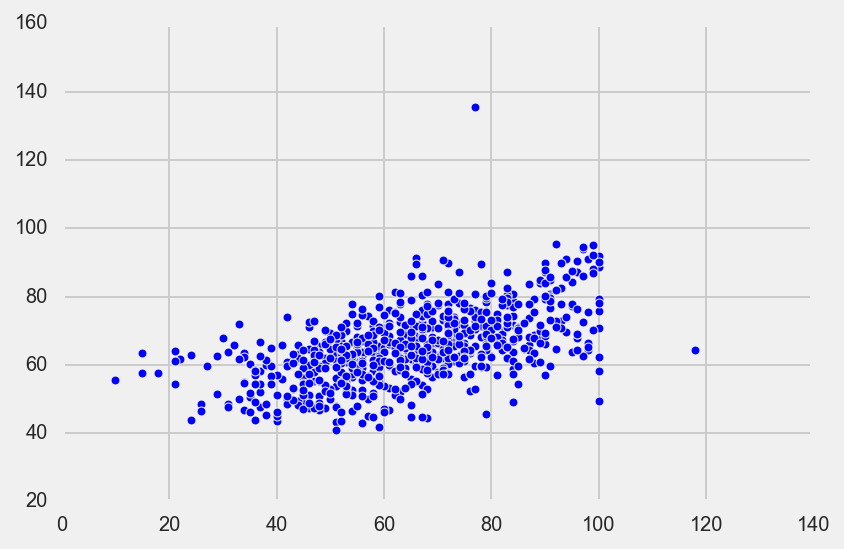

In [46]:
college.head()
lm = LinearRegression()

college.rename(columns={'Grad.Rate':'Grad_Rate',
                        'Room.Board':'Room_Board',
                        'S.F.Ratio':'S_F_Ratio'},inplace=True)

formula = "Grad_Rate ~ Private + Apps + Accept + Enroll + Top10perc + Top25perc"

y,X = patsy.dmatrices(formula, college, return_type = "dataframe")

scores = cross_val_score(lm, X, y, cv=10)
print "Cross-validated scores:", scores

predictions = cross_val_predict(lm, X, y, cv=10)
plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)
print "Cross-Predicted Accuracy:", accuracy

---

### Create a function that will iteratively predict your target from different train-test splits

This will be used to calculate the bias and the variance after this.

Your function should:

1. Accept a model, X predictor matrix/dataframe, y target variable, and a number of random splits to do training and testing on.
2. The output should be a dataframe that has as its first column the true values of y, and all the other columns will be corresponding predicted values of y when that row was in the testing set.
3. It will iterate through the number of splits
4. Create a variable that is the list of row numbers. Use this with `train_test_split` to get out randomized training rows and testing rows for each iteration.
5. Subset your X and y into training and testing
6. Train your model on the training X and training y
7. Predict values of y using the testing X
8. Add the predicted values of y to the dataframe tracking y predictions - the predicted y values should be insert in the correct row so that they match the true value of y in the first column. You can index using the test indices you got out of train_test_split to do this. (The rest of the rows that were part of the training set can be nan for that iteration).


In [58]:
def make_multiple_predictions(model, X, y, random_split_num=100):
    #Intitialize data frame with first column being the true values
    predictions = pd.DataFrame({'y_true':y})
    
    #Create indices that we will use test_train_split to randomly sort
    indices = range(len(y))
    
    for i in range(random_split_num):
        #Gets indices for train and test set this round
        train_inds, test_inds = train_test_split(rows,test_size=0.3)
        
        #Subset the x and y into training data
        Xtrain,Xtest = X.iloc[train_inds,:], X.iloc[test_inds,:]
        ytrain,ytest = y.iloc[train_inds,:], y.iloc[test_inds,:]
        
        #Train the model
        model.fit(Xtrain,ytrain)
        
        #get out the predictions
        yhats = model.predict(Xtest)
        
        #Append results to data frame
        predictions['Sample '+ str(i+1)] = np.nan
        predictions.iloc[test_inds,-1] = yhats
        
    return prediction

---

### Create different predictor datasets

To see what happens to bias and variance as the predictors change, create a few versions of X that have different numbers of predictors in them.

For example, one could have all the other variables, and another one could be predicting only using private vs. public.

In [59]:
lm = LinearRegression()

formula = {
            'formula1': "Grad_Rate ~ Private + Apps + Accept + Enroll + Top10perc + Top25perc",
            'formula2': "Grad_Rate ~ Room_Board + Books + Personal",
            'formula3': "Grad_Rate ~ S_F_Ratio"
          }

y,X1 = patsy.dmatrices(formula['formula1'], college, return_type = "dataframe")
y,X2 = patsy.dmatrices(formula['formula2'], college, return_type = "dataframe")
y,X3 = patsy.dmatrices(formula['formula3'], college, return_type = "dataframe")

make_multiple_predictions(lm, X1, y, random_split_num=100)
make_multiple_predictions(lm, X2, y, random_split_num=100)
make_multiple_predictions(lm, X3, y, random_split_num=100)

ValueError: If using all scalar values, you must pass an index

---

### Use the predict function you wrote above to get the predicted values for each version of the data

Run each of your X through the function with the y target vector. As you recall the output of your function has the true values of y in a column and then predicted values of y in other columns for the different train-test splits

---

### Calculate bias and variance 

I've given you two functions below to calculate bias and variance if they are given the dataframe that has the first column as the true y values and the other column the predicted y values at each train/test split iteration.

You can use these to calculate the bias and variance of your different predictor variables. If you have more predictors variance of prediction should generally go up and bias goes down. Likewise, if you have few predictors variance should go down and bias goes up.

If you have an insanely bad model, they both might go up a lot!

In [3]:
def calculate_bias_sq(yhats_df):
    # Take out the true values of y that are in the first column:
    ytrue = yhats_df.iloc[:,0].values
    
    # Calculate the mean of the predictions, averaged across the columns.
    # So, all of the predictions for the true y at row 0 would be averaged together
    # and so on for all the rows.
    yhat_means = yhats_df.iloc[:,1:].mean(axis=1).values
    
    # Subtract the true value of y from the mean of the predicted values, and square it.
    elementwise_bias_sq = (yhat_means - ytrue)**2
    
    # Take the mean of those squared bias values (across all y)
    mean_bias_sq = np.mean(elementwise_bias_sq)
    return mean_bias_sq


def calculate_variance(yhats_df):
    # Calculate the mean of the predicted y's across the columns (mean of yhat for each row)
    yhats_means = yhats_df.iloc[:,1:].mean(axis=1)
    
    # subtract the mean of the yhats from the original yhat values (for each row)
    # and square the result. 
    yhats_devsq = yhats_df.iloc[:,1:].subtract(yhats_means, axis=0)**2
    
    # Take the mean of the squared deviations from the mean, then 
    # take the mean of those to get the overall variance across the y observations
    yhats_devsq_means = yhats_devsq.mean(axis=1).values
    return np.mean(yhats_devsq_means)


In [60]:
import math
math.factorial(17)

355687428096000

---

### How does regularization affect bias and variance?

Use Lasso and/or Ridge on your dataset with all the predictor variables. You can feed the lasso or ridge model into the function you wrote earlier to get the predictions using regularization instead of just ordinary least squares regression.

How does using regularization affect bias and variance?